# Fisrt we define a simulator

## In this example we will use Class to generate $C_l$

### First, let us import the required packages 

In [10]:
#Below we define paths to some files that are required for simulations
import sys
import numpy as np
#path_to_file = 'path/to/cosmoped'
#this is the path to the CosMOPED package in case if u want to use MOPED compression otherwise ignore
path_to_file = '/Users/aisulu/Desktop/moped_sbi/cosmoped'
if path_to_file not in sys.path:
    sys.path.append(path_to_file)
#path=path/to/compression_vectors
path='/Users/aisulu/Desktop/report_code/LambdaCDM/'

#file_path = path/to/experimental_noise noise compatible with the Planck experiment
#this is the path to the noise file compatible with the Planck experiment
#if you do not include experiemntal noise in your simulations, ignore
file_path = '/Users/aisulu/Desktop/report_code/noise_fake_planck_realistic_two.dat'
try:
    fpr = np.loadtxt(file_path)
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

#Now we load the actual packages
import matplotlib.pyplot as plt
import healpy as hp
from classy import Class
from copy import deepcopy
from scipy import stats
import pickle
from cosmoped_likelihood import CosMOPED

#Below is just for plots
%matplotlib inline
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

### Define certain constants such as $l_{max}$ and also get the MOPED compression vectors

In [5]:
lmax=2500
fsky=1.0
ell=np.array([l for l in range(2,lmax+1)])
ells=ell*(ell+1)/(2*np.pi)

Nltt = fpr[ell-2,1] #this is experimental noise in TT polarisation

TT2018=CosMOPED(path, year=2018, spectra='TT', use_low_ell_bins=False) #to get compression vectors
compression_vector_dict, compressed_data_dict = TT2018.read_compression_vectors_and_compressed_data(path)
compress_vec_h = compression_vector_dict['h'][:2499]
compress_vec_ombh2 = compression_vector_dict['omega_b'][:2499]
compress_vec_omch2 = compression_vector_dict['omega_cdm'][:2499]
compress_vec_As = compression_vector_dict['A_s'][:2499]
compress_vec_ns = compression_vector_dict['n_s'][:2499]

### Define the simulator which uses Class

In [23]:
def simulator(v, exp_noise = True):
    V=np.around(v, decimals=6)
    h, omega_b, omega_cdm, lnAs,n_s=V[0],V[1],V[2],V[3],V[4]
    A_s=np.exp(lnAs)/ 1.e10
    params = {
        'output': 'tCl pCl lCl',
        'l_max_scalars': lmax,
        'lensing': 'yes',
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'A_s': A_s,
        'n_s': n_s,
    }
    cosmo = Class()
    cosmo.set(params)
    try:
        cosmo.compute(['lensing'])
        cls = cosmo.lensed_cl(lmax)
        T=cosmo.T_cmb()
        cosmo.struct_cleanup()
        cosmo.empty()
        if exp_noise == True:
            return dict(TT=cls['tt'][ell]*(T*1.e6)**2+Nltt)
        else: 
            return dict(TT=cls['tt'][ell]*(T*1.e6)**2)
    except Exception as e:
        print("a simulation failed!")
        print(f"An error occurred: {e}")
        return dict(TT=np.nan)

### Define fiducial cosmology

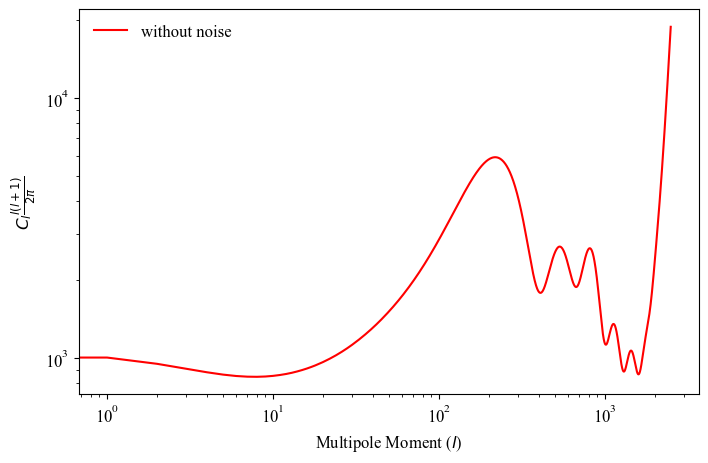

In [17]:
pl=[0.676, 0.0224, 0.12, 3.0753, 0.965]
obs = simulator(pl)

plt.figure(figsize = (8, 5))
plt.plot(obs['TT']*ells, label = r'without noise', color = 'red')
plt.xlabel('Multipole Moment ($l$)')
plt.ylabel(r'$C_l \frac{l(l+1)}{2 \pi}$')
plt.legend(frameon=False, loc = 'upper left')
plt.yscale('log')
plt.xscale('log')

### Define the covariance matrix

In [19]:
covmat=np.diag(obs['TT']**2)*2/((2*ell+1)*fsky)
icovmat=np.linalg.inv(covmat)

### Generate noise vectors

In [20]:
noisevecs = np.random.multivariate_normal(np.zeros(2499),covmat,size=100000)

### Define the noise model

Use the Wishart distribution for cosmic variance 

In [21]:
def noise(power_spectrum):
    cat = np.array(power_spectrum['TT'])
    CLTT=[]
    for l in range(2,2+49):
        nm=int(np.round(fsky*(2*l+1)))
        g1=np.random.randn(nm)
        almT=np.sqrt(power_spectrum['TT'][l-2])*g1
        CLTT.append((((nm))**-1 *np.sum((almT**2))))
    NN=noisevecs[np.random.randint(0,100000)]
    noise=np.concatenate((np.zeros(29+20), NN[29+20:2499]))
    cat[:49]=np.array(CLTT)
    cat=cat+noise
    return {'TT': cat[:2499]}

### Testing the simulator with  fiducial cosmology

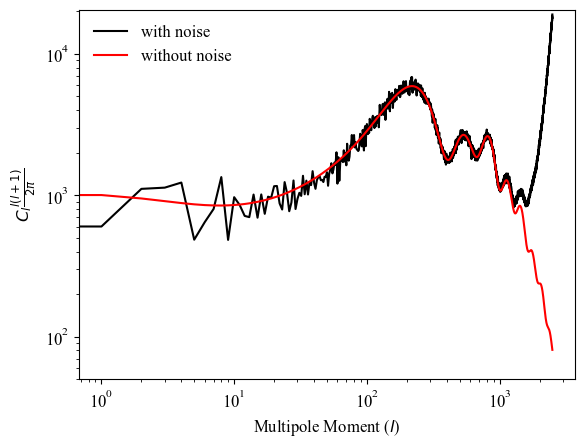

In [25]:
np.random.seed(0)
pl=[0.676, 0.0224, 0.12, 3.0753, 0.965]
obs = simulator(pl)
obs2 = simulator(pl, exp_noise = False) #for power spectrum with no experimental noise and no cosmic variance
plt.plot(noise(obs)['TT']*ells, label = 'with noise', color = 'black');
plt.plot(obs2['TT']*ells, label = 'without noise', color = 'red');
plt.yscale('log');
plt.xscale('log');
plt.xlabel('Multipole Moment ($l$)')
plt.ylabel(r'$C_l \frac{l(l+1)}{2 \pi}$')
plt.ylim([50, 20500])
plt.legend(frameon=False)

# To do SBI we need to define a reasonable prior

## Finite derivative

In [26]:
def finiteD(k, eps=1e-2):
    parr=list(pl)
    parr[k]=pl[k]*(1+eps)
    parr2=list(pl)
    parr2[k]=pl[k]*(1-eps)
    m1=simulator(parr)
    m2=simulator(parr2)
    output=(m1['TT']-m2['TT'])/(pl[k]*(2*eps))
    return output

ders=[finiteD(i) for i in range(5)]

## Compute Fisher matrix

In [27]:
F=np.zeros((5,5))
for i in range(5):
    for j in range(5):
        d1=ders[i]
        if i != j: 
            d2=ders[j]
        else: 
            d2=d1
        term1=np.dot(d1,np.matmul(icovmat,d2))
        F[i,j]=term1

Finv=np.linalg.inv(F)

## Check approximation 

In [30]:
#For good approximation printed values must be close to one
def lnL(fid,test):
    diff = np.array(fid['TT']-test['TT'])
    exp = -0.5*np.dot(diff, np.matmul(icovmat, diff))
    scale = np.sqrt(2*np.pi*np.linalg.norm(icovmat))
    return exp - np.log(scale)
def finiteD2LNL(k, eps=1e-2):
    parr=list(pl)
    parr[k]=pl[k]*(1+eps)
    parr2=list(pl)
    parr2[k]=pl[k]*(1-eps)
    m1=simulator(parr)
    m2=simulator(parr2)
    m0=simulator(pl)
    return (lnL(m0,m1)+lnL(m0,m2)-2*lnL(m0,m0))/(pl[k]*eps)**2
f00=finiteD2LNL(0)
f11=finiteD2LNL(1)
f22=finiteD2LNL(2)
f33=finiteD2LNL(3)
f44=finiteD2LNL(4)

print(-F[0][0]/f00)
print(-F[1][1]/f11)
print(-F[2][2]/f22)
print(-F[3][3]/f33)
print(-F[4][4]/f44)

0.9995755484274969
0.9993960289177947
0.9992149130543785
0.9997619545057851
0.999978095274557


## Compute sigmas

In [33]:
sigss=[]
for i in range(5): sigss.append(np.sqrt(Finv[i,i]));
print(sigss)

[0.007280314019205051, 0.00016000424178571937, 0.001652310824066368, 0.003472400357728407, 0.004155629403002546]


In [34]:
sigss = [0.007280314019205051, 0.00016000424178571937, 0.001652310824066368, 0.003472400357728407, 0.004155629403002546] 
#we save sigss so that we dont need to redo the whole process again and can just run this cell

## Define a unifrom prior

### A reasonable prior has a width of 10 sigmas. We want to have a very wide prior to experiment with truncation

In [36]:
def find_bounds(k):
    hw = 24 * sigss[k]
    min = pl[k] - hw
    max = pl[k] + hw
    return min, max
param_min = []
param_max = []
for i in range(5):
    min, max = find_bounds(i)
    param_min.append(min)
    param_max.append(max)

print(param_min)
print(param_max)

[0.5012724635390788, 0.018559898197142734, 0.08034454022240717, 2.991962391414518, 0.8652648943279388]
[0.8507275364609213, 0.026240101802857265, 0.15965545977759282, 3.1586376085854817, 1.064735105672061]


In [37]:
param_min = [0.5012724635390788, 0.018559898197142734, 0.08034454022240717, 2.991962391414518, 0.8652648943279388]
param_max = [0.8507275364609213, 0.026240101802857265, 0.15965545977759282, 3.1586376085854817, 1.064735105672061]

# MOPED compression

In [39]:
def moped_compress(power_spectrum):
    output = [compress_vec_h.dot(power_spectrum), compress_vec_ombh2.dot(power_spectrum), compress_vec_omch2.dot(power_spectrum), 
              compress_vec_As.dot(power_spectrum),compress_vec_ns.dot(power_spectrum)] 
    #note that power_spectrum must be given in cls, not dls
    #the way that compression vectors are computed means that the order matters!
    return output

# Here we define simulator wrappers to make it easier for us to use later

In [41]:
def simulator_wrapper_moped(params):
    sim = simulator(np.array(params))
    noise_sim = noise(sim)['TT']
    compressed = moped_compress(noise_sim)
    return compressed

def simulator_wrapper(params):
    sim = simulator(np.array(params))
    noise_sim = noise(sim)['TT']
    uncompressed = noise_sim*ells #to train NN on dl_hats instead of cl_hats
    return uncompressed

def simulator_wrapper_moped_xo(params):
    #for "noiseless" data, use a rescaled observation. This is mainly to compare with "typical" forecasting MCMC
    sim = simulator(np.array(params))
    for i in range(49):
        l=i+2
        nm=np.round(fsky*(2*l+1))
        sim['TT'][i]*=((nm-1)/(nm-2))**-0.5
    cltt = sim['TT']
    compressed = moped_compress(cltt) #the x_o for sbi
    return compressed
    
def simulator_wrapper_xo(params):
    #for "noiseless" data, use a rescaled observation. This is mainly to compare with "typical" forecasting MCMC
    sim = simulator(np.array(params))
    for i in range(49):
        l=i+2
        nm=np.round(fsky*(2*l+1))
        sim['TT'][i]*=((nm-1)/(nm-2))**-0.5
    cltt = sim['TT']
    uncompressed = cltt*ells #the x_o for sbi
    return uncompressed

### Lets check simulators

In [42]:
#For uncompressed data
obs = simulator_wrapper_xo(pl)
obs_noisy = simulator_wrapper(pl)

#For compressed data
obs_comp = simulator_wrapper_moped(pl)
obs_comp_noisy = simulator_wrapper_moped_xo(pl)

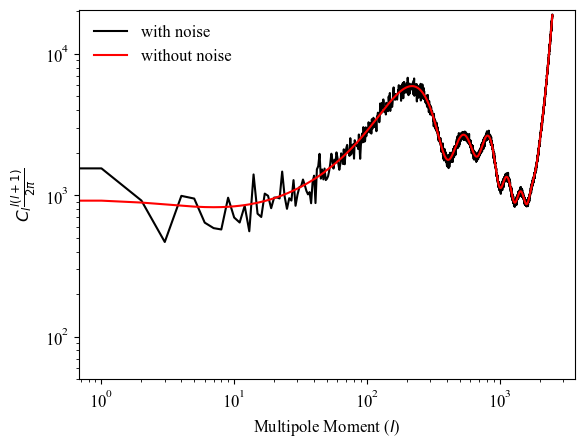

In [43]:
plt.plot(obs_noisy, label = 'with noise', color = 'black');
plt.plot(obs, label = 'without noise', color = 'red');
plt.yscale('log');
plt.xscale('log');
plt.xlabel('Multipole Moment ($l$)')
plt.ylabel(r'$C_l \frac{l(l+1)}{2 \pi}$')
plt.ylim([50, 20500])
plt.legend(frameon=False)

In [50]:
print(obs_comp)
print(obs_comp_noisy)

[40.17202355348796, -374.3224056190632, -329.5996997153745, 82.80387574860652, -458.34449364202146]
[40.916065562024656, -375.08000057475914, -330.8041589505855, 82.36023190474184, -457.04285418499836]
